## 📦 Paso 0: Instalación de Dependencias

In [1]:
# === INSTALACIÓN DE DEPENDENCIAS ===

print("📦 Instalando dependencias necesarias...")
print("-" * 60)

# Instalar category_encoders (necesario para TargetEncoder)
!pip install shap category-encoders --quiet


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from category_encoders import TargetEncoder
import time
import warnings

print("\n🎉 Setup completado. Puedes continuar con el assignment.")


# Importar librerías necesarias
warnings.filterwarnings('ignore')

# Configuración
np.random.seed(42)
plt.style.use('seaborn-v0_8')  # establecer estilo visual (ej: 'seaborn-v0_8', 'default')
sns.set_palette("husl")  # definir paleta de colores (ej: 'Set2', 'husl')

print("✅ Entorno configurado para encoding avanzado")

📦 Instalando dependencias necesarias...
------------------------------------------------------------



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\ignac\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



🎉 Setup completado. Puedes continuar con el assignment.
✅ Entorno configurado para encoding avanzado


## 💰 Paso 2: Cargar Dataset Real - Adult Income (Census)

In [2]:
# === CARGAR DATASET REAL: ADULT INCOME ===

print("💰 CARGANDO DATASET: ADULT INCOME (US CENSUS)")
print("=" * 60)

# Este dataset es del UCI ML Repository - clásico para benchmarking
# Predice si el ingreso anual supera $50K basándose en datos del censo de 1994

# OPCIÓN 1: Cargar desde URL (si tienes conexión a internet)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Nombres de columnas (el dataset no tiene header)
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)  # función para leer CSV

# 1. Limpiar datos
print("\n🧹 Limpiando datos...")

# Remover espacios en blanco de las categorías
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()  # método para eliminar espacios en blanco

# Manejar valores faltantes
print(f"   Valores faltantes antes: {df.isnull().sum().sum()}")
df = df.dropna(how='any')  # método para eliminar filas con NaN
print(f"   Valores faltantes después: {df.isnull().sum().sum()}")
print(f"   Registros después de limpieza: {len(df):,}")

# 2. Crear target binario
df['target'] = (df['income'] == '>50K').astype(int)

print(f"\n📊 Dataset shape: {df.shape}")
print(f"📊 Distribución del target:")
print(f"   <=50K: {(df['target']==0).sum():,} ({(df['target']==0).mean():.1%})")
print(f"   >50K:  {(df['target']==1).sum():,} ({(df['target']==1).mean():.1%})")

# 3. Identificar columnas categóricas (excluir target e income)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'income' in categorical_cols:
    categorical_cols.remove('income')
if 'target' in categorical_cols:
    categorical_cols.remove('target')

print(f"\n🔍 Variables categóricas encontradas: {len(categorical_cols)}")
print(categorical_cols)
# 4. Analizar cardinalidad
print("\n🔍 ANÁLISIS DE CARDINALIDAD:")
for col in categorical_cols:
    n_unique = df[col].nunique()
    cardinality_type = 'BAJA' if n_unique <= 10 else ('MEDIA' if n_unique <= 50 else 'ALTA')
    print(f"   {col}: {n_unique} categorías únicas ({cardinality_type})")

print("\n🔍 Primeras 5 filas:")
print(df.head())  # método para mostrar primeras filas

print("\n💡 CONTEXTO DEL DATASET:")
print("   Dataset del US Census (1994) - clásico de Machine Learning")
print("   Target: Ingreso >50K/año (clasificación binaria)")
print("   Variables categóricas: workclass, education, occupation, etc.")
print("   Alta cardinalidad: native-country (42 países)")
print("   Accuracy típica: 80-85% (más desafiante que hoteles)")

💰 CARGANDO DATASET: ADULT INCOME (US CENSUS)

🧹 Limpiando datos...
   Valores faltantes antes: 0
   Valores faltantes después: 0
   Registros después de limpieza: 32,561

📊 Dataset shape: (32561, 16)
📊 Distribución del target:
   <=50K: 24,720 (75.9%)
   >50K:  7,841 (24.1%)

🔍 Variables categóricas encontradas: 8
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

🔍 ANÁLISIS DE CARDINALIDAD:
   workclass: 9 categorías únicas (BAJA)
   education: 16 categorías únicas (MEDIA)
   marital-status: 7 categorías únicas (BAJA)
   occupation: 15 categorías únicas (MEDIA)
   relationship: 6 categorías únicas (BAJA)
   race: 5 categorías únicas (BAJA)
   sex: 2 categorías únicas (BAJA)
   native-country: 42 categorías únicas (MEDIA)

🔍 Primeras 5 filas:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2  

## 🔢 Paso 3: Análisis de Cardinalidad


🔍 ANÁLISIS DE CARDINALIDAD
📊 CLASIFICACIÓN POR CARDINALIDAD:
✅ Baja cardinalidad (≤10): 5 columnas
   ['workclass', 'marital-status', 'relationship', 'race', 'sex']
⚠️  Media cardinalidad (11-50): 3 columnas
   ['education', 'occupation', 'native-country']
🚨 Alta cardinalidad (>50): 0 columnas
   []

🚨 PROBLEMA DE DIMENSIONALIDAD CON ONE-HOT:
   workclass: 9 categorías → 8 columnas one-hot
   education: 16 categorías → 15 columnas one-hot
   marital-status: 7 categorías → 6 columnas one-hot
   occupation: 15 categorías → 14 columnas one-hot
   relationship: 6 categorías → 5 columnas one-hot
   race: 5 categorías → 4 columnas one-hot
   sex: 2 categorías → 1 columnas one-hot
   native-country: 42 categorías → 41 columnas one-hot

❌ Total columnas con one-hot: 94
❌ Original: 8 columnas → 94 columnas
❌ Explosión dimensional: 11.8x


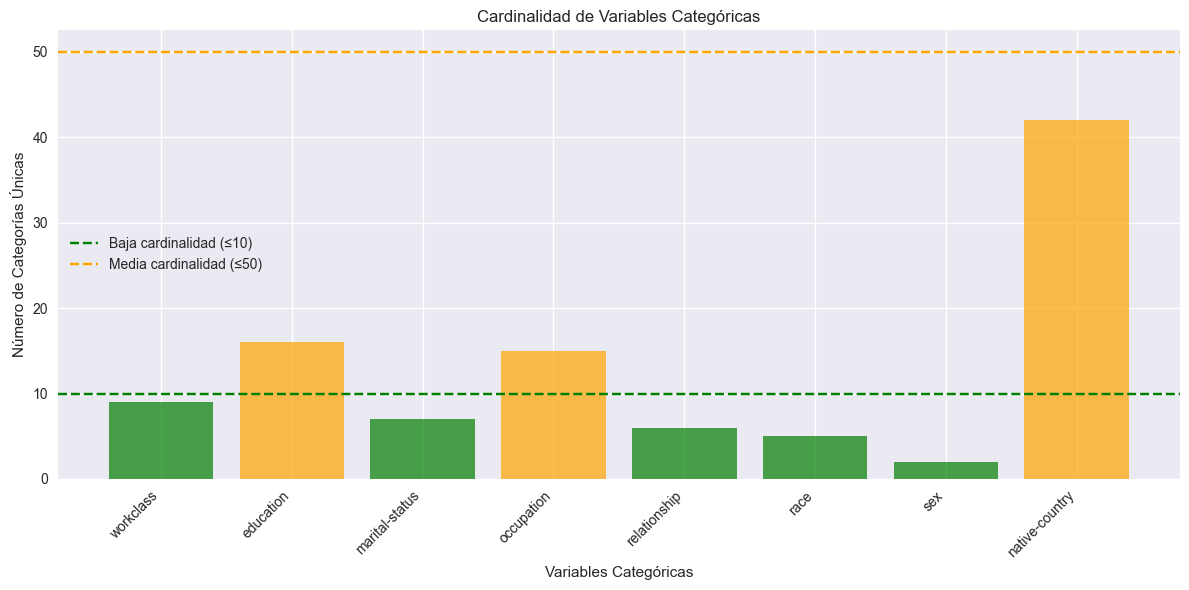


💡 CONCLUSIÓN:
   One-hot encoding NO es viable para variables de alta cardinalidad
   Necesitamos técnicas alternativas: Label, Target, Hash, Binary encoding


In [3]:
# === ANÁLISIS DE CARDINALIDAD Y PROBLEMAS DE ONE-HOT ===

print("\n🔍 ANÁLISIS DE CARDINALIDAD")
print("=" * 60)

# 1. Clasificar columnas por cardinalidad
def classify_cardinality(df, categorical_cols):
    """Clasificar columnas por cardinalidad"""
    low_card = []
    medium_card = []
    high_card = []

    for col in categorical_cols:
        n_unique = df[col].nunique()
        if n_unique <= 10:
            low_card.append(col)
        elif n_unique <= 50:
            medium_card.append(col)
        else:
            high_card.append(col)

    return low_card, medium_card, high_card

low_card_cols, medium_card_cols, high_card_cols = classify_cardinality(df, categorical_cols)

print("📊 CLASIFICACIÓN POR CARDINALIDAD:")
print(f"✅ Baja cardinalidad (≤10): {len(low_card_cols)} columnas")
print(f"   {low_card_cols}")
print(f"⚠️  Media cardinalidad (11-50): {len(medium_card_cols)} columnas")
print(f"   {medium_card_cols}")
print(f"🚨 Alta cardinalidad (>50): {len(high_card_cols)} columnas")
print(f"   {high_card_cols}")

# 2. Calcular dimensionalidad con One-Hot
print("\n🚨 PROBLEMA DE DIMENSIONALIDAD CON ONE-HOT:")

total_onehot_columns = 0
for col in categorical_cols:
    n_categories = df[col].nunique()
    n_onehot_cols = n_categories - 1  # drop='first'
    total_onehot_columns += n_onehot_cols
    print(f"   {col}: {n_categories} categorías → {n_onehot_cols} columnas one-hot")

print(f"\n❌ Total columnas con one-hot: {total_onehot_columns}")
print(f"❌ Original: {len(categorical_cols)} columnas → {total_onehot_columns} columnas")
print(f"❌ Explosión dimensional: {total_onehot_columns / len(categorical_cols):.1f}x")

# 3. Visualizar distribución de cardinalidad
fig, ax = plt.subplots(figsize=(12, 6))

cardinalities = [df[col].nunique() for col in categorical_cols]
colors = ['green' if c <= 10 else ('orange' if c <= 50 else 'red') for c in cardinalities]

ax.bar(categorical_cols, cardinalities, color=colors, alpha=0.7)
ax.axhline(y=10, color='green', linestyle='--', label='Baja cardinalidad (≤10)')
ax.axhline(y=50, color='orange', linestyle='--', label='Media cardinalidad (≤50)')
ax.set_xlabel('Variables Categóricas')
ax.set_ylabel('Número de Categorías Únicas')
ax.set_title('Cardinalidad de Variables Categóricas')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n💡 CONCLUSIÓN:")
print("   One-hot encoding NO es viable para variables de alta cardinalidad")
print("   Necesitamos técnicas alternativas: Label, Target, Hash, Binary encoding")

## 🏷️ Paso 4: Experimento 1 - Label Encoding

In [4]:
# === EXPERIMENTO 1: LABEL ENCODING ===

print("\n🏷️ EXPERIMENTO 1: LABEL ENCODING")
print("=" * 60)

def experiment_label_encoding(df, categorical_cols, target_col='target'):
    """
    Implementar Label Encoding y evaluar performance
    """

    # 1. Preparar datos
    # Seleccionar variables numéricas del dataset Adult Income
    numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
                   'capital-loss', 'hours-per-week']

    X = df[categorical_cols + numeric_cols].copy()
    y = df[target_col]

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Aplicar Label Encoding
    print("🔄 Aplicando Label Encoding...")

    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()

        # Fit en train
        X_train_encoded[col] = le.fit_transform(X_train[col])  # método para fit y transform

        # Transform en test (manejar categorías no vistas)
        # TODO: ¿Cómo manejar categorías en test que no aparecen en train?
        le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
        X_test_encoded[col] = X_test[col].map(le_dict).fillna(-1).astype(int)

        label_encoders[col] = le

    # 3. Entrenar modelo
    print("🌲 Entrenando Random Forest...")

    start_time = time.time()

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_encoded, y_train)  # método para entrenar modelo

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = model.predict(X_test_encoded)  # método para hacer predicciones
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results = {
        'encoding': 'Label Encoding',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_encoded.shape[1]
    }

    print(f"✅ Label Encoding completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_encoded.shape[1]}")

    return results, model, label_encoders

# Ejecutar experimento
results_label, model_label, label_encoders = experiment_label_encoding(df, categorical_cols)


🏷️ EXPERIMENTO 1: LABEL ENCODING
🔄 Aplicando Label Encoding...
🌲 Entrenando Random Forest...
✅ Label Encoding completado
   📊 Accuracy: 0.8632
   📊 AUC-ROC: 0.9101
   📊 F1-Score: 0.6931
   ⏱️  Training time: 0.45s
   📏 Features: 14


## 🔥 Paso 5: Experimento 2 - One-Hot Encoding (Solo Baja Cardinalidad)

In [5]:
# === EXPERIMENTO 2: ONE-HOT ENCODING (SOLO BAJA CARDINALIDAD) ===

print("\n🔥 EXPERIMENTO 2: ONE-HOT ENCODING (BAJA CARDINALIDAD)")
print("=" * 60)

def experiment_onehot_encoding(df, low_card_cols, numeric_cols, target_col='target'):
    """
    Implementar One-Hot Encoding solo para variables de baja cardinalidad
    """

    # 1. Preparar datos (solo baja cardinalidad + numéricas)
    feature_cols = low_card_cols + numeric_cols
    X = df[feature_cols].copy()
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Aplicar One-Hot Encoding
    print("🔄 Aplicando One-Hot Encoding...")

    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

    # Separar categóricas y numéricas
    X_train_cat = X_train[low_card_cols]
    X_train_num = X_train[numeric_cols]
    X_test_cat = X_test[low_card_cols]
    X_test_num = X_test[numeric_cols]

    # Encode categóricas
    X_train_cat_encoded = encoder.fit_transform(X_train_cat)  # método para fit y transform
    X_test_cat_encoded = encoder.transform(X_test_cat)    # método para solo transform

    # Combinar con numéricas
    X_train_encoded = np.hstack([X_train_cat_encoded, X_train_num.values])
    X_test_encoded = np.hstack([X_test_cat_encoded, X_test_num.values])

    print(f"   📊 Features after one-hot: {X_train_encoded.shape[1]}")
    print(f"   📊 Categóricas: {low_card_cols}")
    print(f"   📊 Columnas one-hot: {X_train_cat_encoded.shape[1]}")

    # 3. Entrenar modelo
    print("🌲 Entrenando Random Forest...")

    start_time = time.time()

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_encoded, y_train)

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = model.predict(X_test_encoded)
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results = {
        'encoding': 'One-Hot (low card only)',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_encoded.shape[1]
    }

    print(f"✅ One-Hot Encoding completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_encoded.shape[1]}")

    return results, model, encoder

# Ejecutar experimento
# Definir variables numéricas del Adult Income dataset
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
               'capital-loss', 'hours-per-week']

results_onehot, model_onehot, onehot_encoder = experiment_onehot_encoding(df, low_card_cols, numeric_cols)


🔥 EXPERIMENTO 2: ONE-HOT ENCODING (BAJA CARDINALIDAD)
🔄 Aplicando One-Hot Encoding...
   📊 Features after one-hot: 30
   📊 Categóricas: ['workclass', 'marital-status', 'relationship', 'race', 'sex']
   📊 Columnas one-hot: 24
🌲 Entrenando Random Forest...
✅ One-Hot Encoding completado
   📊 Accuracy: 0.8483
   📊 AUC-ROC: 0.8995
   📊 F1-Score: 0.6633
   ⏱️  Training time: 0.43s
   📏 Features: 30


## 🎯 Paso 6: Experimento 3 - Target Encoding (Alta Cardinalidad)

In [6]:
# === EXPERIMENTO 3: TARGET ENCODING (ALTA CARDINALIDAD) ===

print("\n🎯 EXPERIMENTO 3: TARGET ENCODING (ALTA CARDINALIDAD)")
print("=" * 60)

def experiment_target_encoding(df, high_card_cols, numeric_cols, target_col='target'):
    """
    Implementar Target Encoding con cross-validation para prevenir leakage
    """

    # 1. Preparar datos
    feature_cols = high_card_cols + numeric_cols
    X = df[feature_cols].copy()
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Aplicar Target Encoding
    print("🔄 Aplicando Target Encoding...")
    print("⚠️  IMPORTANTE: Usando cross-validation para prevenir DATA LEAKAGE")

    # TODO: ¿Por qué es importante usar CV para target encoding?
    # PISTA: ¿Qué pasa si calculamos el promedio del target usando el mismo registro?

    # Crear encoder de category_encoders
    encoder = TargetEncoder(cols=high_card_cols, smoothing=10.0)  # parámetro de smoothing (ej: 1.0, 10.0, 100.0)

    # Separar categóricas y numéricas
    X_train_cat = X_train[high_card_cols]
    X_train_num = X_train[numeric_cols]
    X_test_cat = X_test[high_card_cols]
    X_test_num = X_test[numeric_cols]

    # Encode categóricas (TargetEncoder necesita el target)
    X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)  # método para fit y transform con target
    X_test_cat_encoded = encoder.transform(X_test_cat)              # método para solo transform

    # Combinar con numéricas
    X_train_encoded = pd.concat([X_train_cat_encoded.reset_index(drop=True), 
                                 X_train_num.reset_index(drop=True)], axis=1)
    X_test_encoded = pd.concat([X_test_cat_encoded.reset_index(drop=True), 
                                X_test_num.reset_index(drop=True)], axis=1)

    print(f"   📊 Features after target encoding: {X_train_encoded.shape[1]}")
    print(f"   📊 Categóricas codificadas: {high_card_cols}")
    print(f"   📊 Ejemplo de encoding:")
    for col in high_card_cols[:2]:  # mostrar primeras 2 columnas
        print(f"      {col}: min={X_train_cat_encoded[col].min():.3f}, "
              f"max={X_train_cat_encoded[col].max():.3f}, "
              f"mean={X_train_cat_encoded[col].mean():.3f}")

    # 3. Entrenar modelo
    print("🌲 Entrenando Random Forest...")

    start_time = time.time()

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_encoded, y_train)

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = model.predict(X_test_encoded)
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results = {
        'encoding': 'Target Encoding (high card)',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_encoded.shape[1]
    }

    print(f"✅ Target Encoding completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_encoded.shape[1]}")

    return results, model, encoder

# Ejecutar experimento
results_target, model_target, target_encoder = experiment_target_encoding(df, high_card_cols, numeric_cols)


🎯 EXPERIMENTO 3: TARGET ENCODING (ALTA CARDINALIDAD)
🔄 Aplicando Target Encoding...
⚠️  IMPORTANTE: Usando cross-validation para prevenir DATA LEAKAGE
   📊 Features after target encoding: 6
   📊 Categóricas codificadas: []
   📊 Ejemplo de encoding:
🌲 Entrenando Random Forest...
✅ Target Encoding completado
   📊 Accuracy: 0.8021
   📊 AUC-ROC: 0.8272
   📊 F1-Score: 0.5538
   ⏱️  Training time: 0.43s
   📏 Features: 6


## 🌳 Paso 7: Pipeline con Branching - ColumnTransformer

In [7]:
# === PIPELINE CON BRANCHING: COLUMNTRANSFORMER ===

print("\n🌳 PIPELINE CON BRANCHING: COLUMNTRANSFORMER")
print("=" * 60)

def create_branched_pipeline(low_card_cols, high_card_cols, numeric_cols):
    """
    Crear pipeline con múltiples ramas para diferentes tipos de encoding
    """

    print("🔧 Creando pipeline con branching...")
    print(f"   🌿 Rama 1: One-Hot para baja cardinalidad ({len(low_card_cols)} cols)")
    print(f"   🌿 Rama 2: Target Encoding para alta cardinalidad ({len(high_card_cols)} cols)")
    print(f"   🌿 Rama 3: StandardScaler para numéricas ({len(numeric_cols)} cols)")

    # TODO: Definir transformadores para cada rama

    # RAMA 1: One-Hot para baja cardinalidad
    onehot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    # RAMA 2: Target Encoding para alta cardinalidad
    target_transformer = Pipeline(steps=[
        ('target', TargetEncoder(smoothing=10.0))
    ])

    # RAMA 3: Scaling para numéricas
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # COLUMNTRANSFORMER: Combina todas las ramas
    preprocessor = ColumnTransformer(
        transformers=[
            ('low_card', onehot_transformer, low_card_cols),
            ('high_card', target_transformer, high_card_cols),
            ('num', numeric_transformer, numeric_cols)
        ],
        remainder='drop'  # qué hacer con columnas no especificadas ('drop', 'passthrough')
    )

    # PIPELINE COMPLETO: Preprocessor + Modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ])

    print("✅ Pipeline creado con éxito")

    return pipeline, preprocessor

def experiment_branched_pipeline(df, low_card_cols, high_card_cols, numeric_cols, target_col='target'):
    """
    Evaluar pipeline con branching
    """

    # 1. Preparar datos
    all_features = low_card_cols + high_card_cols + numeric_cols
    X = df[all_features].copy()
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Crear pipeline
    pipeline, preprocessor = create_branched_pipeline(low_card_cols, high_card_cols, numeric_cols)

    # 3. Entrenar pipeline completo
    print("\n🔄 Entrenando pipeline completo...")

    start_time = time.time()

    pipeline.fit(X_train, y_train)  # método para entrenar pipeline

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = pipeline.predict(X_test)  # método para hacer predicciones
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    # 5. Analizar features transformadas
    print("\n📊 ANÁLISIS DE FEATURES TRANSFORMADAS:")

    X_train_transformed = preprocessor.fit_transform(X_train, y_train)

    print(f"   📏 Features originales: {X_train.shape[1]}")
    print(f"   📏 Features después de transformación: {X_train_transformed.shape[1]}")

    # TODO: ¿Cuántas columnas one-hot se crearon?
    # PISTA: Usar get_feature_names_out() del preprocessor

    results = {
        'encoding': 'Branched Pipeline (mixed)',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_transformed.shape[1]
    }

    print(f"\n✅ Pipeline con branching completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_transformed.shape[1]}")

    return results, pipeline, X_test, y_test

# Ejecutar experimento
results_pipeline, pipeline, X_test_pipeline, y_test_pipeline = experiment_branched_pipeline(df, low_card_cols, high_card_cols, numeric_cols)


🌳 PIPELINE CON BRANCHING: COLUMNTRANSFORMER
🔧 Creando pipeline con branching...
   🌿 Rama 1: One-Hot para baja cardinalidad (5 cols)
   🌿 Rama 2: Target Encoding para alta cardinalidad (0 cols)
   🌿 Rama 3: StandardScaler para numéricas (6 cols)
✅ Pipeline creado con éxito

🔄 Entrenando pipeline completo...

📊 ANÁLISIS DE FEATURES TRANSFORMADAS:
   📏 Features originales: 11
   📏 Features después de transformación: 30

✅ Pipeline con branching completado
   📊 Accuracy: 0.8485
   📊 AUC-ROC: 0.8996
   📊 F1-Score: 0.6646
   ⏱️  Training time: 0.44s
   📏 Features: 30


## 🔍 Paso 7.5: Explicabilidad - Feature Importance y SHAP


🔍 EXPLICABILIDAD: FEATURE IMPORTANCE
🌲 1. FEATURE IMPORTANCE - RANDOM FOREST
------------------------------------------------------------

📊 Analizando modelo con Pipeline Branching...
✅ Features extraídas: 30
🔝 Top Features más importantes:
                                       feature  importance
                                   num__fnlwgt    0.223091
                                      num__age    0.165969
                            num__education-num    0.132941
                             num__capital-gain    0.114665
                           num__hours-per-week    0.092367
   low_card__marital-status_Married-civ-spouse    0.084835
                             num__capital-loss    0.037539
        low_card__marital-status_Never-married    0.030943
                            low_card__sex_Male    0.017424
          low_card__relationship_Not-in-family    0.015534
              low_card__relationship_Own-child    0.010421
                   low_card__relationship_Wife   

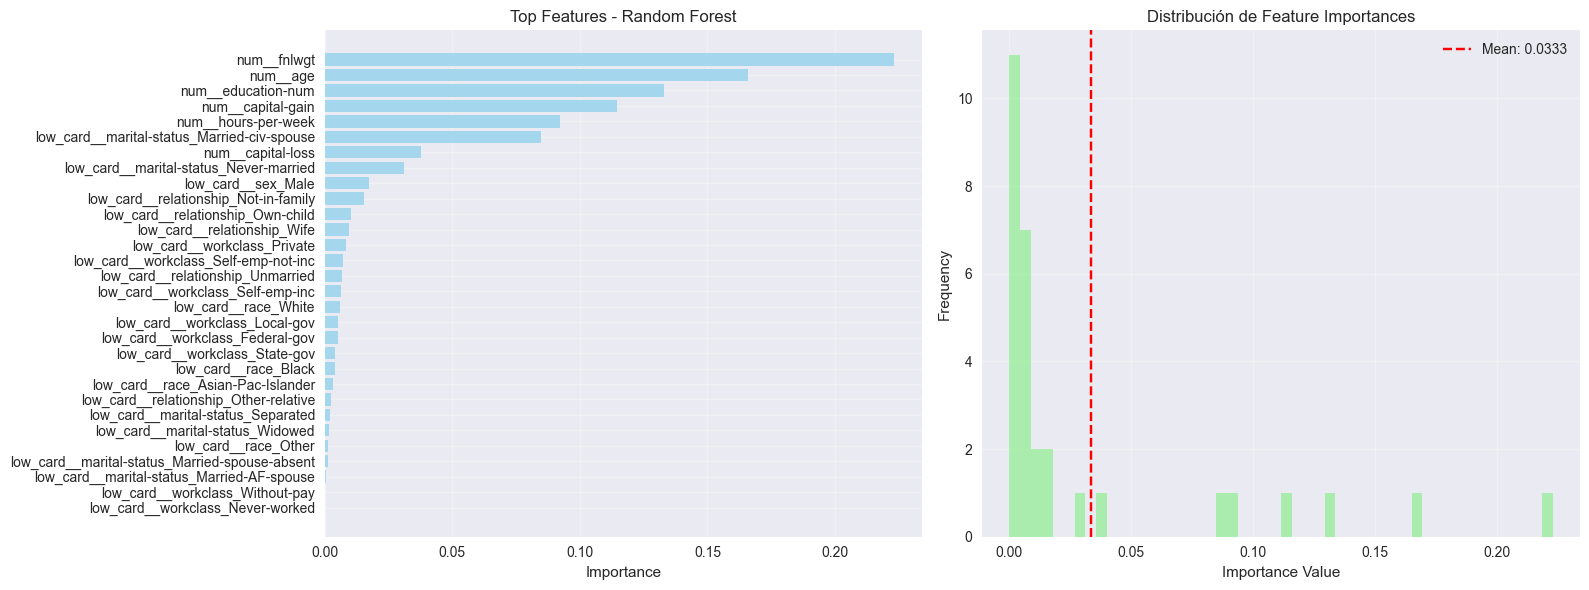


📊 2. COMPARACIÓN DE IMPORTANCIA POR MÉTODO
------------------------------------------------------------
📊 Comparando importancia entre métodos...


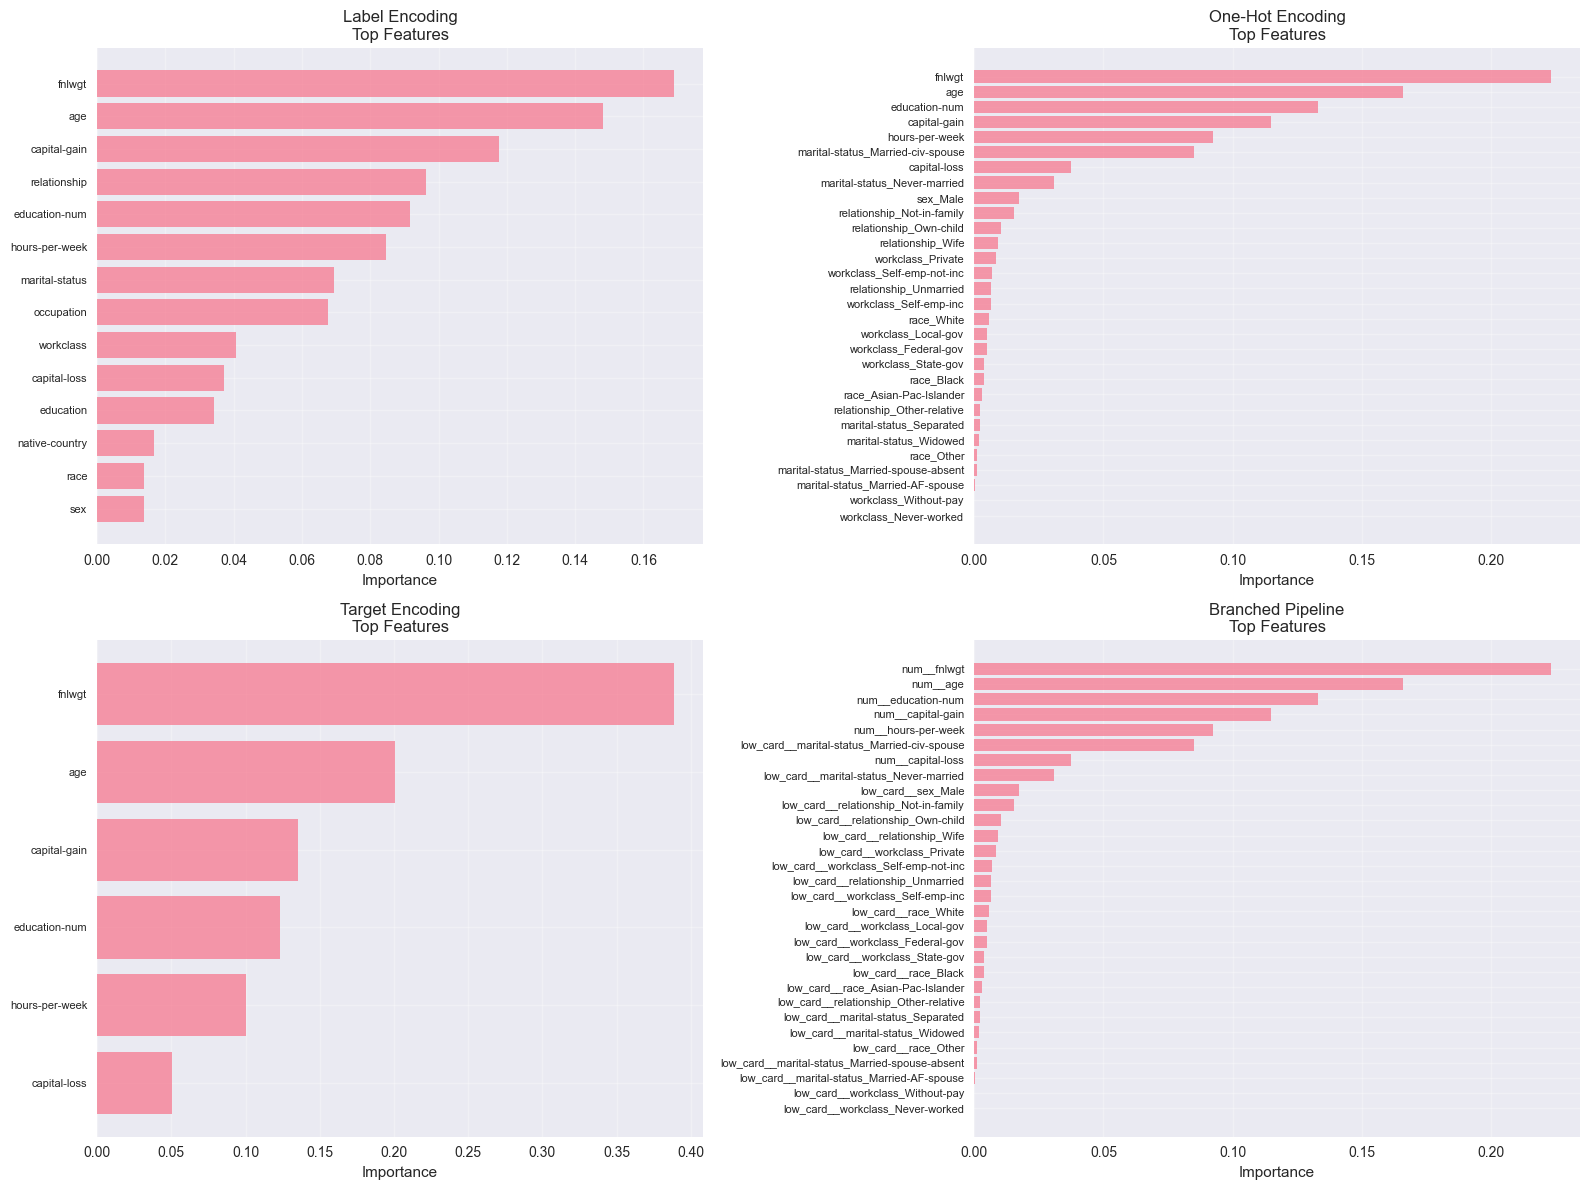


🔍 4. ANÁLISIS DE FEATURES CODIFICADAS
------------------------------------------------------------

📊 Análisis para encoding: Branched Pipeline

📊 Importancia por tipo de feature:
                    sum    mean  count
type                                  
Numérica         0.7666  0.1278      6
One-Hot Encoded  0.2334  0.0097     24


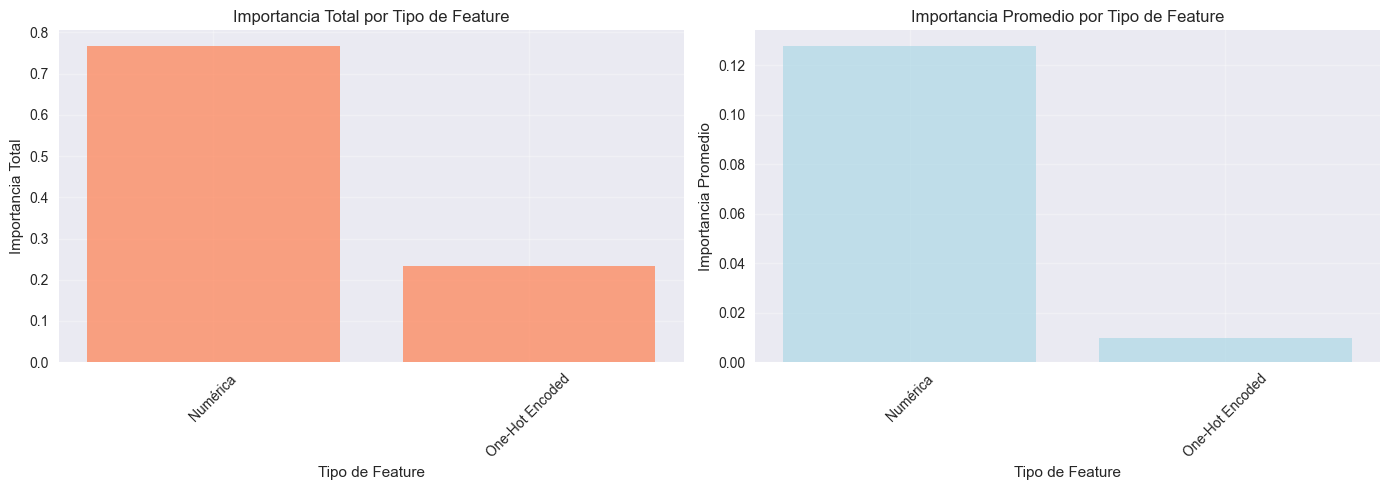


💡 CONCLUSIONES DE EXPLICABILIDAD:

🔍 PREGUNTAS PARA REFLEXIONAR:

1. ¿Qué features son más importantes para el modelo?
   - ¿Son variables numéricas o categóricas codificadas?
   - ¿Las features de alta cardinalidad (target encoded) son importantes?

2. ¿Cómo afecta el encoding a la importancia?
   - ¿One-hot encoding captura bien la información?
   - ¿Target encoding genera features más predictivas?

3. ¿Qué tipo de features dominan el modelo?
   - ¿Variables numéricas originales?
   - ¿Variables categóricas codificadas?
   - ¿Hay diferencias entre métodos de encoding?

4. ¿Los resultados de SHAP confirman la importancia del Random Forest?
   - ¿Hay features que SHAP identifica como importantes pero RF no?
   - ¿Las interacciones entre features son significativas?

5. ¿Qué implicaciones tiene esto para el negocio?
   - ¿Qué factores realmente predicen el ingreso?
   - ¿Hay insights accionables de las features importantes?



In [8]:
# === EXPLICABILIDAD: ANÁLISIS DE FEATURE IMPORTANCE ===

print("\n🔍 EXPLICABILIDAD: FEATURE IMPORTANCE")
print("=" * 60)

# 1. Feature Importance del Random Forest
print("🌲 1. FEATURE IMPORTANCE - RANDOM FOREST")
print("-" * 60)
def analyze_feature_importance(model, feature_names):
    """
    Analizar y visualizar feature importance del Random Forest
    """

    # Obtener importancia de features
    importances = model.feature_importances_  # atributo que contiene las importancias

    # Crear DataFrame para ordenar
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print(f"🔝 Top Features más importantes:")
    print(importance_df.to_string(index=False))

    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Top N features
    top_features = importance_df
    ax1.barh(range(len(top_features)), top_features['importance'], color='skyblue', alpha=0.7)
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['feature'])
    ax1.set_xlabel('Importance')
    ax1.set_title(f'Top Features - Random Forest')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3)

    # Distribución de importancias
    ax2.hist(importances, bins=50, alpha=0.7, color='lightgreen')
    ax2.set_xlabel('Importance Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribución de Feature Importances')
    ax2.axvline(importances.mean(), color='red', linestyle='--', label=f'Mean: {importances.mean():.4f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return importance_df

# Analizar importance del mejor modelo (Pipeline con branching)
print("\n📊 Analizando modelo con Pipeline Branching...")

# Obtener nombres de features después de transformación
feature_names_out = pipeline.named_steps['preprocessor'].get_feature_names_out()
print(f"✅ Features extraídas: {len(feature_names_out)}")

# Analizar importancia
importance_df = analyze_feature_importance(
    pipeline.named_steps['classifier'], 
    feature_names_out
)

# 2. Comparar importancia entre métodos de encoding
print("\n📊 2. COMPARACIÓN DE IMPORTANCIA POR MÉTODO")
print("-" * 60)

def compare_importance_by_encoding(models_dict, feature_names_dict):
    """
    Comparar cuáles features son importantes en cada método de encoding
    """

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for idx, (name, model) in enumerate(models_dict.items()):
        if idx >= 4:
            break

        # Obtener importancias
        importances = model.feature_importances_
        features = feature_names_dict[name]

        # Top 10
        importance_df = pd.DataFrame({
            'feature': features,
            'importance': importances
        }).sort_values('importance', ascending=False)

        # Visualizar
        axes[idx].barh(range(len(importance_df)), importance_df['importance'], alpha=0.7)
        axes[idx].set_yticks(range(len(importance_df)))
        axes[idx].set_yticklabels(importance_df['feature'], fontsize=8)
        axes[idx].set_xlabel('Importance')
        axes[idx].set_title(f'{name}\nTop Features')
        axes[idx].invert_yaxis()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Preparar datos para comparación
models_dict = {
    'Label Encoding': model_label,
    'One-Hot Encoding': model_onehot,
    'Target Encoding': model_target,
    'Branched Pipeline': pipeline.named_steps['classifier']
}

# TODO: Definir feature names para cada modelo
# PISTA: Necesitas saber qué features tiene cada modelo después del encoding
feature_names_dict = {
    'Label Encoding': categorical_cols + numeric_cols,
    'One-Hot Encoding': list(onehot_encoder.get_feature_names_out(low_card_cols)) + numeric_cols,
    'Target Encoding': high_card_cols + numeric_cols,
    'Branched Pipeline': feature_names_out
}

print("📊 Comparando importancia entre métodos...")
compare_importance_by_encoding(models_dict, feature_names_dict)

# 4. Análisis de Features Codificadas
print("\n🔍 4. ANÁLISIS DE FEATURES CODIFICADAS")
print("-" * 60)

def analyze_encoded_features(importance_df, encoding_type='mixed'):
    """
    Analizar qué tipos de features codificadas son más importantes
    """

    print(f"\n📊 Análisis para encoding: {encoding_type}")

    # Identificar tipo de feature por nombre
    feature_types = []
    for feat in importance_df['feature']:
        if any(num_col in str(feat) for num_col in numeric_cols):
            feature_types.append('Numérica')
        elif 'target_enc' in str(feat).lower() or any(hc in str(feat) for hc in high_card_cols):
            feature_types.append('Target Encoded')
        elif any(lc in str(feat) for lc in low_card_cols):
            feature_types.append('One-Hot Encoded')
        else:
            feature_types.append('Otra')

    importance_df['type'] = feature_types

    # Agrupar por tipo
    type_importance = importance_df.groupby('type')['importance'].agg(['sum', 'mean', 'count'])
    type_importance = type_importance.sort_values('sum', ascending=False)

    print("\n📊 Importancia por tipo de feature:")
    print(type_importance.round(4))

    # Visualizar
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Importancia total por tipo
    ax1.bar(type_importance.index, type_importance['sum'], alpha=0.7, color='coral')
    ax1.set_xlabel('Tipo de Feature')
    ax1.set_ylabel('Importancia Total')
    ax1.set_title('Importancia Total por Tipo de Feature')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)

    # Importancia promedio por tipo
    ax2.bar(type_importance.index, type_importance['mean'], alpha=0.7, color='lightblue')
    ax2.set_xlabel('Tipo de Feature')
    ax2.set_ylabel('Importancia Promedio')
    ax2.set_title('Importancia Promedio por Tipo de Feature')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return type_importance

# Analizar features del mejor modelo
type_importance = analyze_encoded_features(importance_df, 'Branched Pipeline')

print("\n💡 CONCLUSIONES DE EXPLICABILIDAD:")
print("=" * 60)
print("""
🔍 PREGUNTAS PARA REFLEXIONAR:

1. ¿Qué features son más importantes para el modelo?
   - ¿Son variables numéricas o categóricas codificadas?
   - ¿Las features de alta cardinalidad (target encoded) son importantes?

2. ¿Cómo afecta el encoding a la importancia?
   - ¿One-hot encoding captura bien la información?
   - ¿Target encoding genera features más predictivas?

3. ¿Qué tipo de features dominan el modelo?
   - ¿Variables numéricas originales?
   - ¿Variables categóricas codificadas?
   - ¿Hay diferencias entre métodos de encoding?

4. ¿Los resultados de SHAP confirman la importancia del Random Forest?
   - ¿Hay features que SHAP identifica como importantes pero RF no?
   - ¿Las interacciones entre features son significativas?

5. ¿Qué implicaciones tiene esto para el negocio?
   - ¿Qué factores realmente predicen el ingreso?
   - ¿Hay insights accionables de las features importantes?
""")

1. Age, fnlwg y education num. Las primeras dos son numéricas y la tercera es es categórica codificada. 
La variable education tiene una cardinalidad media (16 categorías → 15 columnas one-hot)

2. 
    - One-Hot Encoding logró capturar bien la información de variables con baja cardinalidad, manteniendo una buena interpretabilidad, pero aumenta la dimensionalidad (aprox 11 veces más columnas).

    - Label Encoding generó resultados sólidos y simples, aunque puede introducir una relación ordinal artificial entre categorías que no la tienen.

    - Target Encoding, aplicado a las de mayor cardinalidad, resultó útil pero menos destacable aquí por la ausencia de columnas con muchas categorías.
    En términos de métricas, las diferencias fueron pequeñas, aunque Label Encoding y Branched Pipeline mostraron un mejor balance entre rendimiento y eficiencia.

3. Las variables numéricas originales dominaron claramente al modelo, tanto en importancia total como promedio.
Esto se confirma en el gráfico de barras donde las numéricas sumaron cerca del 77% de la importancia total, frente a un 23% correspondiente a las categóricas codificadas (one-hot).
Las diferencias entre métodos de encoding fueron leves, pero se observó que los numéricos mantuvieron su protagonismo en todos los enfoques.
Esto sugiere que, en este dataset, la información estructural y cuantitativa (edad, años de educación, capital, horas trabajadas) es mucho más informativa que las categorías sociales o demográficas.

4.  - Las variables numéricas (age, education-num, capital-gain, hours-per-week) continúan siendo las más influyentes sobre la probabilidad de tener ingresos mayores a 50K.

    - SHAP también muestra que las interacciones entre sex y marital-status influyen levemente, reflejando sesgos estructurales (por ejemplo, hombres casados tienden a tener mayor probabilidad de alto ingreso).

    - No aparecen nuevas features altamente relevantes que el Random Forest haya ignorado, lo cual indica consistencia entre ambas metodologías.

5.  - Los factores que más predicen el ingreso son edad, nivel educativo, tipo de empleo y capital acumulado, lo que coincide con patrones socioeconómicos reales.

    - Las categorías relacionadas con el estado civil también inciden, lo que puede reflejar correlaciones indirectas con estabilidad laboral o responsabilidades familiares.

    - No se detectaron variables categóricas con alta cardinalidad que aporten valor adicional.

    - Para aplicaciones prácticas, esto implica que los modelos predictivos de ingresos pueden simplificarse priorizando las variables numéricas, reduciendo complejidad sin perder rendimiento.

    - Además, es importante considerar posibles sesgos de género o de relación familiar, ya que el modelo podría reproducir desigualdades presentes en los datos originales del censo.


## 📊 Paso 8: Comparación de Resultados


📊 COMPARACIÓN DE MÉTODOS DE ENCODING

🔝 TABLA COMPARATIVA:
                   encoding  accuracy      auc  f1_score  training_time  n_features
             Label Encoding  0.863197 0.910143  0.693076       0.451456          14
    One-Hot (low card only)  0.848303 0.899538  0.663258       0.430049          30
Target Encoding (high card)  0.802088 0.827227  0.553825       0.429059           6
  Branched Pipeline (mixed)  0.848457 0.899563  0.664628       0.438236          30

🏆 MEJORES MÉTODOS POR MÉTRICA:
   🎯 Mejor Accuracy: Label Encoding (0.8632)
   🎯 Mejor AUC-ROC: Label Encoding (0.9101)
   🎯 Mejor F1-Score: Label Encoding (0.6931)
   ⚡ Más rápido: Target Encoding (high card) (0.43s)
   📏 Menos features: Target Encoding (high card) (6 features)


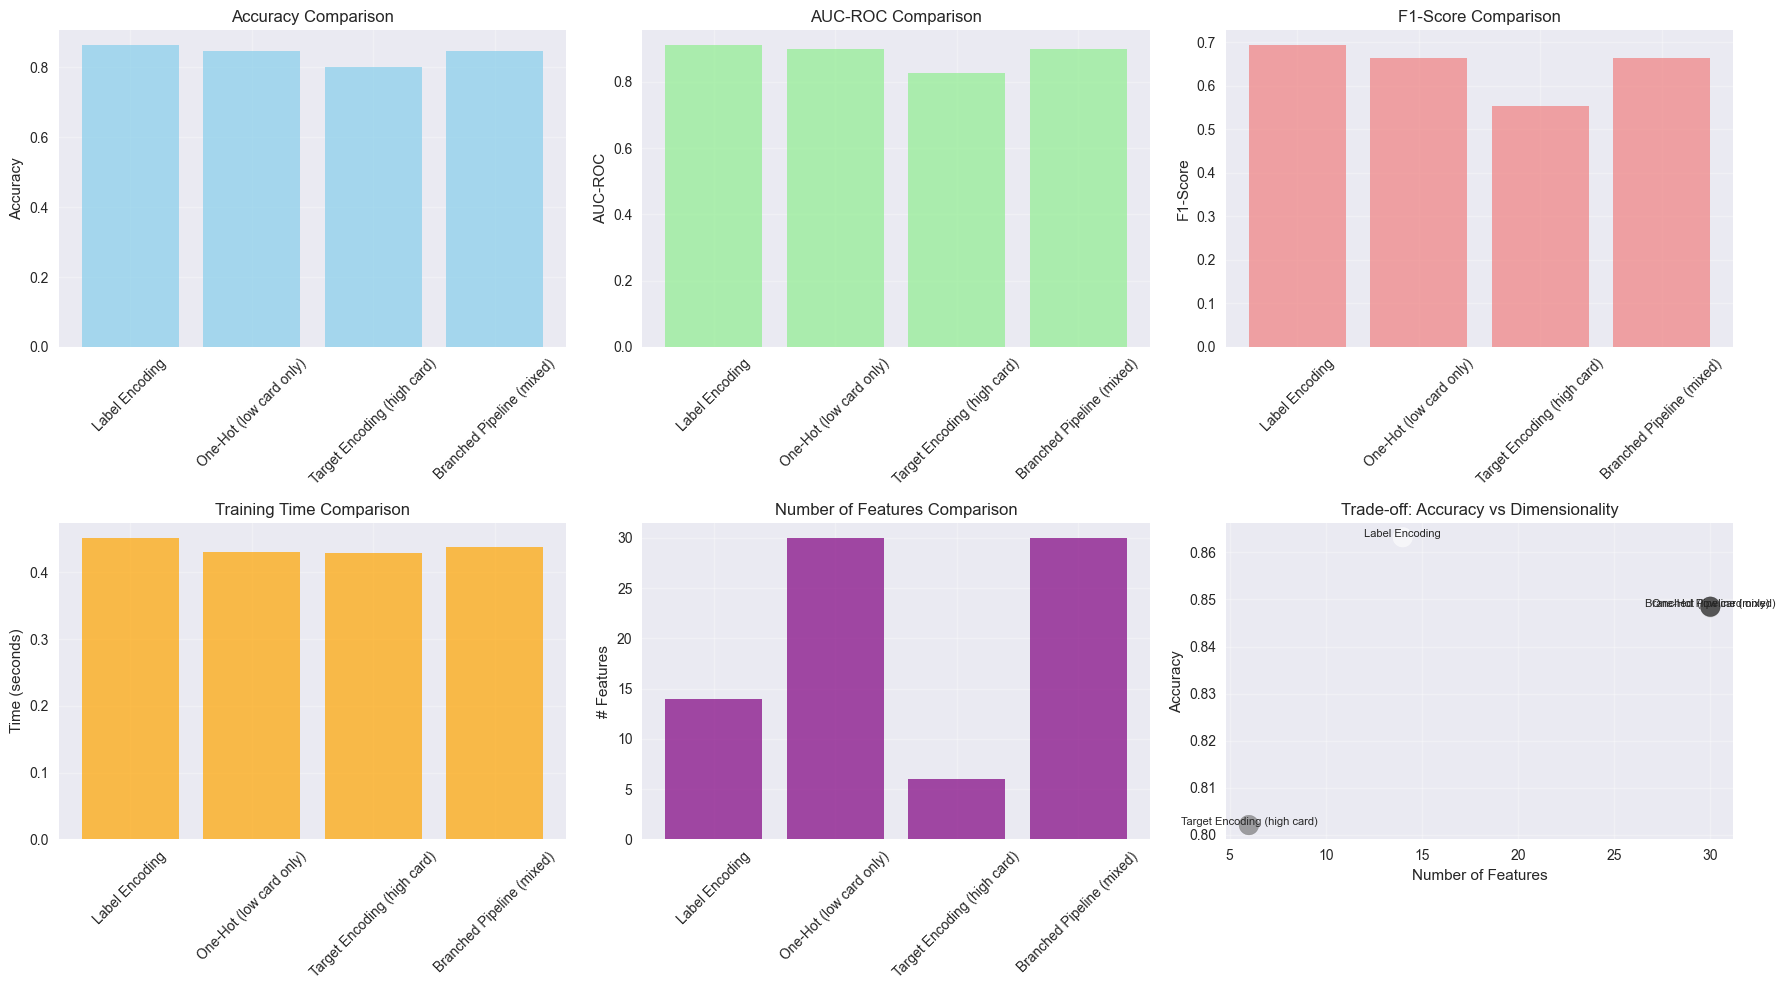


📊 ANÁLISIS DE TRADE-OFFS:
------------------------------------------------------------
🔍 Accuracy vs Dimensionalidad:
   Label Encoding: 0.8632 accuracy con 14 features
   Target Encoding: 0.8021 accuracy con 6 features


In [10]:
# === COMPARACIÓN DE TODOS LOS MÉTODOS ===

print("\n📊 COMPARACIÓN DE MÉTODOS DE ENCODING")
print("=" * 60)

# 1. Consolidar resultados
all_results = [
    results_label,
    results_onehot,
    results_target,
    results_pipeline
]

results_df = pd.DataFrame(all_results)

# 2. Mostrar tabla comparativa
print("\n🔝 TABLA COMPARATIVA:")
print(results_df.to_string(index=False))

# 3. Identificar mejor método por métrica
print("\n🏆 MEJORES MÉTODOS POR MÉTRICA:")
print(f"   🎯 Mejor Accuracy: {results_df.loc[results_df['accuracy'].idxmax(), 'encoding']} "
      f"({results_df['accuracy'].max():.4f})")
print(f"   🎯 Mejor AUC-ROC: {results_df.loc[results_df['auc'].idxmax(), 'encoding']} "
      f"({results_df['auc'].max():.4f})")
print(f"   🎯 Mejor F1-Score: {results_df.loc[results_df['f1_score'].idxmax(), 'encoding']} "
      f"({results_df['f1_score'].max():.4f})")
print(f"   ⚡ Más rápido: {results_df.loc[results_df['training_time'].idxmin(), 'encoding']} "
      f"({results_df['training_time'].min():.2f}s)")
print(f"   📏 Menos features: {results_df.loc[results_df['n_features'].idxmin(), 'encoding']} "
      f"({results_df['n_features'].min()} features)")

# 4. Visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy
axes[0, 0].bar(results_df['encoding'], results_df['accuracy'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# AUC-ROC
axes[0, 1].bar(results_df['encoding'], results_df['auc'], color='lightgreen', alpha=0.7)
axes[0, 1].set_title('AUC-ROC Comparison')
axes[0, 1].set_ylabel('AUC-ROC')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# F1-Score
axes[0, 2].bar(results_df['encoding'], results_df['f1_score'], color='lightcoral', alpha=0.7)
axes[0, 2].set_title('F1-Score Comparison')
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3)

# Training Time
axes[1, 0].bar(results_df['encoding'], results_df['training_time'], color='orange', alpha=0.7)
axes[1, 0].set_title('Training Time Comparison')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Number of Features
axes[1, 1].bar(results_df['encoding'], results_df['n_features'], color='purple', alpha=0.7)
axes[1, 1].set_title('Number of Features Comparison')
axes[1, 1].set_ylabel('# Features')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Trade-off: Accuracy vs Features
axes[1, 2].scatter(results_df['n_features'], results_df['accuracy'], s=200, alpha=0.6, c=range(len(results_df)))
for i, txt in enumerate(results_df['encoding']):
    axes[1, 2].annotate(txt, (results_df.iloc[i]['n_features'], results_df.iloc[i]['accuracy']), 
                       fontsize=8, ha='center')
axes[1, 2].set_xlabel('Number of Features')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Trade-off: Accuracy vs Dimensionality')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Análisis de trade-offs
print("\n📊 ANÁLISIS DE TRADE-OFFS:")
print("-" * 60)

# TODO: Completa el análisis
print("🔍 Accuracy vs Dimensionalidad:")
print(f"   Label Encoding: {results_df[results_df['encoding']=='Label Encoding']['accuracy'].values[0]:.4f} accuracy "
      f"con {results_df[results_df['encoding']=='Label Encoding']['n_features'].values[0]} features")
print(f"   Target Encoding: {results_df[results_df['encoding']=='Target Encoding (high card)']['accuracy'].values[0]:.4f} accuracy "
      f"con {results_df[results_df['encoding']=='Target Encoding (high card)']['n_features'].values[0]} features")

### 🔍 Accuracy vs Tiempo

En tiempos de entrenamiento, todos los métodos fueron similares (~0.43–0.45 s), por lo que el costo computacional no es un factor determinante.
Aun así:

- Target Encoding fue el más rápido (0.43 s), debido a la baja cantidad de columnas.

- Label Encoding fue apenas más lento (0.45 s), pero con una ganancia importante en precisión.

- One-Hot y Branched Pipeline tuvieron tiempos levemente mayores por la expansión del número de variables.

El pequeño costo adicional de Label Encoding se justifica por la mejora en todas las métricas de rendimiento.


### 🔍 Recomendación para Producción

Para un sistema productivo, el método más recomendable sería Label Encoding, porque:

- Ofrece el mejor rendimiento global (accuracy, AUC y F1-Score).

- Mantiene una baja complejidad dimensional (solo 14 features).

- Es fácil de implementar y mantener sin inflar el espacio de variables.

- Evita el problema de explosión de columnas del one-hot encoding.

- Y conserva interpretabilidad sin riesgo de data leakage, a diferencia del target encoding.

El Pipeline mixto (branched) es una buena opción modular para contextos donde coexisten variables de distinta cardinalidad, pero en este dataset concreto no ofrece mejoras sustanciales sobre el Label Encoding.

## 🧪 Paso 9: Investigación Libre - Técnicas Adicionales

In [14]:
# 🎯 DESAFÍO 1: Frequency Encoding
print("🎯 DESAFÍO 1: Frequency Encoding")
print("-" * 40)

def frequency_encoding_train_test(X_train, X_test, col):
    freq = (X_train[col].value_counts(normalize=True))
    X_train_enc = X_train[col].map(freq)
    # Categorías nuevas en test -> 0 (o freq global mínima)
    X_test_enc  = X_test[col].map(freq).fillna(0.0)
    return X_train_enc, X_test_enc

def evaluate_with_extra_feature(df, cat_col, numeric_cols, target_col='target'):
    # Base: SOLO numéricas + la columna a codificar
    X = df[[cat_col] + numeric_cols].copy()
    y = df[target_col].copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Frequency encoding en train -> map a test
    freq = X_train[cat_col].value_counts(normalize=True)
    tr_enc = X_train[cat_col].map(freq)
    te_enc = X_test[cat_col].map(freq).fillna(0.0)

    X_train_fe = pd.concat([X_train[numeric_cols].reset_index(drop=True),
                            tr_enc.rename(f'{cat_col}_freq').reset_index(drop=True)], axis=1)
    X_test_fe  = pd.concat([X_test[numeric_cols].reset_index(drop=True),
                            te_enc.rename(f'{cat_col}_freq').reset_index(drop=True)], axis=1)

    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train_fe, y_train)
    proba = clf.predict_proba(X_test_fe)[:, 1]
    pred  = (proba >= 0.5).astype(int)

    return {
        'encoding': f'Frequency({cat_col})',
        'accuracy': accuracy_score(y_test, pred),
        'auc': roc_auc_score(y_test, proba),
        'f1_score': f1_score(y_test, pred),
        'n_features': X_train_fe.shape[1]
    }

# Ejecutar
results_freq = evaluate_with_extra_feature(df, 'native-country', numeric_cols)
print(results_freq)

print("\n💡 PREGUNTAS:")
print("- ¿Frequency encoding captura información predictiva?")
print("- ¿Tiene riesgo de data leakage?")
print("- ¿Cuándo usar frequency vs target encoding?")

🎯 DESAFÍO 1: Frequency Encoding
----------------------------------------
{'encoding': 'Frequency(native-country)', 'accuracy': 0.8080761553815446, 'auc': 0.831108326798869, 'f1_score': 0.5644599303135889, 'n_features': 7}

💡 PREGUNTAS:
- ¿Frequency encoding captura información predictiva?
- ¿Tiene riesgo de data leakage?
- ¿Cuándo usar frequency vs target encoding?


¿Frequency encoding captura información predictiva?

- Sí, cuando la frecuencia está correlacionada con la probabilidad del target (p. ej., países con distintas tasas de ingreso >50K).

¿Tiene riesgo de data leakage?

- Sería bajo si se calculan las frecuencias solo en train y se mapean en test; sería alto si se hace en todo el dataset.

¿Cuándo usar frequency vs target encoding?

- Útil cuando se quiere simplicidad, bajo riesgo y estabilizar categorías raras. Target encoding suele ser más potente pero más riesgoso sin CV/regularización.


In [15]:
# 🎯 DESAFÍO 2: Ordinal Encoding
print("\n🎯 DESAFÍO 2: Ordinal Encoding")
print("-" * 40)

from sklearn.preprocessing import OrdinalEncoder

education_order = ['High School', 'Bachelor', 'Master', 'PhD']
satisfaction_order = ['Very Low', 'Low', 'Medium', 'High', 'Very High']


def ordinal_encode_train_test(X_train, X_test, col, ordered_list):
    enc = OrdinalEncoder(categories=[ordered_list], handle_unknown='use_encoded_value', unknown_value=-1)
    X_train_enc = enc.fit_transform(X_train[[col]]).ravel()
    X_test_enc  = enc.transform(X_test[[col]]).ravel()
    return X_train_enc, X_test_enc

def evaluate_ordinal_on_education(df, numeric_cols, target_col='target'):
    X = df[['education'] + numeric_cols].copy()
    y = df[target_col].copy()
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    tr_enc, te_enc = ordinal_encode_train_test(Xtr, Xte, 'education', education_order)
    Xtr_fe = pd.concat([Xtr[numeric_cols].reset_index(drop=True),
                        pd.Series(tr_enc, name='education_ordinal')], axis=1)
    Xte_fe = pd.concat([Xte[numeric_cols].reset_index(drop=True),
                        pd.Series(te_enc, name='education_ordinal')], axis=1)

    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(Xtr_fe, ytr)
    proba = clf.predict_proba(Xte_fe)[:,1]
    pred  = (proba >= 0.5).astype(int)

    return {
        'encoding':'Ordinal(education)',
        'accuracy': accuracy_score(yte, pred),
        'auc': roc_auc_score(yte, proba),
        'f1_score': f1_score(yte, pred),
        'n_features': Xtr_fe.shape[1]
    }

results_ordinal = evaluate_ordinal_on_education(df, numeric_cols)
print(results_ordinal)

print("💡 PREGUNTAS:")
print("- ¿Por qué preservar el orden natural es importante?")
print("- ¿Qué modelos se benefician más de ordinal encoding?")
print("- ¿Cómo manejar categorías con orden parcial?")


🎯 DESAFÍO 2: Ordinal Encoding
----------------------------------------
{'encoding': 'Ordinal(education)', 'accuracy': 0.8019345923537541, 'auc': 0.8271865520728009, 'f1_score': 0.5545580110497238, 'n_features': 7}
💡 PREGUNTAS:
- ¿Por qué preservar el orden natural es importante?
- ¿Qué modelos se benefician más de ordinal encoding?
- ¿Cómo manejar categorías con orden parcial?


¿Por qué preservar el orden natural es importante?

- Porque algunos modelos aprovechan monotonicidad (árboles, lineales con interacciones) y se evitan asignaciones arbitrarias de label encoding.

¿Qué modelos se benefician más de ordinal encoding?

- Árboles y lineales (cuando el orden representa escala).

¿Cómo manejar categorías con orden parcial?

- Podés agrupar niveles sin orden claro o usar target/frequency para esos casos.

In [16]:
# 🎯 DESAFÍO 3: Leave-One-Out Encoding
print("\n🎯 DESAFÍO 3: Leave-One-Out Target Encoding")
print("-" * 40)

def loo_encode_train_test(X_train, y_train, X_test, col, prior=None, clip_counts=True):
    # Agregados por categoría en train
    grp = pd.DataFrame({'y': y_train, col: X_train[col]}).groupby(col)['y'].agg(['sum','count'])
    if prior is None:
        prior = y_train.mean()

    # Valores LOO para train: (sum - y_i) / (count - 1)
    # Precomputo media por categoría (sin LOO)
    cat_mean = grp['sum'] / grp['count']

    # Map de sum y count para acceso rápido
    sum_map   = grp['sum'].to_dict()
    count_map = grp['count'].to_dict()

    # Construcción vectorizada para TRAIN
    s = X_train[col].map(sum_map).to_numpy()
    c = X_train[col].map(count_map).to_numpy()
    y = y_train.to_numpy()

    # Evitar división por 0 cuando c==1 -> usar prior
    loo_train = np.where(c>1, (s - y) / (c - 1), prior)

    # Para TEST: usar la media por categoría de TRAIN; categorías nuevas -> prior
    cat_mean_map = cat_mean.to_dict()
    loo_test = X_test[col].map(cat_mean_map).fillna(prior).to_numpy()

    return pd.Series(loo_train, name=f'{col}_loo'), pd.Series(loo_test, name=f'{col}_loo')

def evaluate_loo_on_country(df, numeric_cols, target_col='target'):
    X = df[['native-country'] + numeric_cols].copy()
    y = df[target_col].copy()
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    tr_enc, te_enc = loo_encode_train_test(Xtr, ytr, Xte, 'native-country')

    Xtr_fe = pd.concat([Xtr[numeric_cols].reset_index(drop=True), tr_enc.reset_index(drop=True)], axis=1)
    Xte_fe = pd.concat([Xte[numeric_cols].reset_index(drop=True), te_enc.reset_index(drop=True)], axis=1)

    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(Xtr_fe, ytr)
    proba = clf.predict_proba(Xte_fe)[:,1]
    pred  = (proba >= 0.5).astype(int)

    return {
        'encoding':'LOO(native-country)',
        'accuracy': accuracy_score(yte, pred),
        'auc': roc_auc_score(yte, proba),
        'f1_score': f1_score(yte, pred),
        'n_features': Xtr_fe.shape[1]
    }

results_loo = evaluate_loo_on_country(df, numeric_cols)
print(results_loo)

print("💡 PREGUNTAS:")
print("- ¿Por qué leave-one-out previene overfitting?")
print("- ¿Es más costoso computacionalmente?")
print("- ¿Cuándo usar LOO vs cross-validation?")


🎯 DESAFÍO 3: Leave-One-Out Target Encoding
----------------------------------------
{'encoding': 'LOO(native-country)', 'accuracy': 0.7640104406571473, 'auc': 0.6731719191721177, 'f1_score': 0.05763335377069283, 'n_features': 7}
💡 PREGUNTAS:
- ¿Por qué leave-one-out previene overfitting?
- ¿Es más costoso computacionalmente?
- ¿Cuándo usar LOO vs cross-validation?


¿Por qué leave-one-out previene overfitting?

- Porque no usa el propio target de la fila para codificarla (reduce fuga de información).

¿Es más costoso computacionalmente?

- Moderado (agregados por grupo + transformaciones); suele ser aceptable.

¿Cuándo usar LOO vs cross-validation?

- LOO es simple y efectivo; K-fold target encoding es más robusto en datasets chicos o muy ruidosos.

In [19]:
# 🎯 DESAFÍO 4: Binary Encoding
print("\n🎯 DESAFÍO 4: Binary Encoding")
print("-" * 40)

from category_encoders import BinaryEncoder

def evaluate_binary_encoding(df, cat_col, numeric_cols, target_col='target'):
    # 1) Solo la col categórica + numéricas
    X = df[[cat_col] + numeric_cols].copy()
    y = df[target_col].copy()

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 2) BinaryEncoder: fit SOLO en train
    enc = BinaryEncoder(cols=[cat_col])
    enc.fit(Xtr[[cat_col]])

    # 3) Transform train/test (misma col)
    Xtr_bin = enc.transform(Xtr[[cat_col]])
    Xte_bin = enc.transform(Xte[[cat_col]])

    # 4) Concatenar SIN resetear índices (mantiene alineación)
    Xtr_be = pd.concat([Xtr_bin, Xtr[numeric_cols]], axis=1)
    Xte_be = pd.concat([Xte_bin, Xte[numeric_cols]], axis=1)

    # Chequeos defensivos
    assert len(Xtr_be) == len(ytr), f"Train mismatch: {len(Xtr_be)} vs {len(ytr)}"
    assert len(Xte_be) == len(yte), f"Test mismatch: {len(Xte_be)} vs {len(yte)}"

    # 5) Modelo
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(Xtr_be, ytr)
    proba = clf.predict_proba(Xte_be)[:, 1]
    pred  = (proba >= 0.5).astype(int)

    # 6) Cuántas columnas creó el binary encoding (≈ log2(n_cats))
    created_cols = enc.transform(pd.DataFrame({cat_col: df[cat_col].unique()})).shape[1]

    return {
        'encoding': f'Binary({cat_col})',
        'accuracy': accuracy_score(yte, pred),
        'auc': roc_auc_score(yte, proba),
        'f1_score': f1_score(yte, pred),
        'n_features': Xtr_be.shape[1],
        'created_cols': created_cols
    }

# Ejecutar
results_binary = evaluate_binary_encoding(df, 'native-country', numeric_cols)
print(results_binary)


print("\n💡 PREGUNTAS:")
print("- ¿Por qué binary encoding reduce dimensionalidad?")
print("- ¿Cuántas columnas crea para N categorías?")
print("- ¿En qué escenarios es útil binary encoding?")


🎯 DESAFÍO 4: Binary Encoding
----------------------------------------
{'encoding': 'Binary(native-country)', 'accuracy': 0.8062336864732075, 'auc': 0.8315110346464167, 'f1_score': 0.5571929824561404, 'n_features': 12, 'created_cols': 6}

💡 PREGUNTAS:
- ¿Por qué binary encoding reduce dimensionalidad?
- ¿Cuántas columnas crea para N categorías?
- ¿En qué escenarios es útil binary encoding?


¿Por qué binary encoding reduce dimensionalidad?

- Para N categorías crea ~⌈log₂ N⌉ columnas (vs N-1 de one-hot).

¿Cuántas columnas crea para N categorías?

- Aproximadamente log₂(N) bits.

¿En qué escenarios es útil binary encoding?

- Alta cardinalidad cuando querés compactar sin introducir la dependencia explícita del target (a diferencia de target/LOO).

In [21]:
# 🎯 DESAFÍO 5: Smoothing en Target Encoding
print("\n🎯 DESAFÍO 5: Experimentar con Smoothing")
print("-" * 40)

from category_encoders import TargetEncoder

def evaluate_target_smoothing(df, cat_col, numeric_cols, smoothing_values, target_col='target'):
    # === 1) Preparar splits (solo una vez) ===
    X = df[[cat_col] + numeric_cols].copy()
    y = df[target_col].copy()

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    rows = []
    for sm in smoothing_values:
        # === 2) Fit TargetEncoder SOLO en train, con ytr alineado ===
        te = TargetEncoder(cols=[cat_col], smoothing=sm)
        te.fit(Xtr[[cat_col]], ytr)

        # === 3) Transformar train y test (solo la col categórica) ===
        Xtr_te_cat = te.transform(Xtr[[cat_col]])
        Xte_te_cat = te.transform(Xte[[cat_col]])

        # === 4) Concatenar SIN resetear índices, para no romper la alineación ===
        Xtr_te = pd.concat([Xtr_te_cat, Xtr[numeric_cols]], axis=1)
        Xte_te = pd.concat([Xte_te_cat, Xte[numeric_cols]], axis=1)

        # Chequeos defensivos (si falla, te avisa dónde)
        assert len(Xtr_te) == len(ytr), f"Mismatch train: X={len(Xtr_te)} vs y={len(ytr)}"
        assert len(Xte_te) == len(yte), f"Mismatch test:  X={len(Xte_te)} vs y={len(yte)}"

        # === 5) Modelo y métricas ===
        clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        clf.fit(Xtr_te, ytr)
        proba = clf.predict_proba(Xte_te)[:, 1]
        pred  = (proba >= 0.5).astype(int)

        rows.append({
            'smoothing': sm,
            'accuracy': accuracy_score(yte, pred),
            'auc': roc_auc_score(yte, proba),
            'f1_score': f1_score(yte, pred),
            'n_features': Xtr_te.shape[1]
        })

    return pd.DataFrame(rows).sort_values('smoothing').reset_index(drop=True)

# Ejecutar
smoothing_values = [1, 10, 100, 1000]
results_smoothing = evaluate_target_smoothing(df, 'native-country', numeric_cols, smoothing_values)
print(results_smoothing)


print("\n💡 PREGUNTAS:")
print("- ¿Qué hace el parámetro smoothing?")
print("- ¿Cuándo usar smoothing alto vs bajo?")
print("- ¿Cómo afecta a categorías raras?")


🎯 DESAFÍO 5: Experimentar con Smoothing
----------------------------------------
   smoothing  accuracy       auc  f1_score  n_features
0          1  0.808076  0.828568  0.566875           7
1         10  0.808076  0.831841  0.566875           7
2        100  0.808537  0.832403  0.569257           7
3       1000  0.805927  0.832287  0.563234           7

💡 PREGUNTAS:
- ¿Qué hace el parámetro smoothing?
- ¿Cuándo usar smoothing alto vs bajo?
- ¿Cómo afecta a categorías raras?


¿Qué hace el parámetro smoothing?

- Interpola entre la media global del target y la media por categoría; a mayor smoothing, más “tira” hacia la media global (menos varianza).

¿Cuándo usar smoothing alto vs bajo?

- Alto (p. ej. 100–1000): cuando hay muchas categorías raras o dataset chico → evita overfitting.

- Bajo (p. ej. 1–10): cuando hay muestras suficientes por categoría y querés capturar diferencias finas.

¿Cómo afecta a categorías raras?

- Con smoothing alto, las categorías poco frecuentes quedan más cercanas a la media global (más robustas, menos ruido).

## 📝 Paso 10: Reflexión y Documentación

In [23]:
# === REFLEXIÓN FINAL ===

print("\n📝 REFLEXIÓN Y CONCLUSIONES")
print("=" * 60)

print("""
🎯 PREGUNTAS DE REFLEXIÓN OBLIGATORIAS:

1. COMPARACIÓN DE MÉTODOS:
   - ¿Cuál método de encoding funcionó mejor en tu dataset?
   - ¿Por qué crees que ese método fue superior?
   - ¿Los resultados coinciden con tu intuición inicial?

2. TRADE-OFFS:
   - ¿Qué trade-offs identificaste entre accuracy, tiempo y dimensionalidad?
   - ¿Qué método recomendarías para producción y por qué?
   - ¿Cómo balancearías performance vs complejidad?

3. DATA LEAKAGE:
   - ¿Qué técnicas usaste para prevenir data leakage en target encoding?
   - ¿Por qué es crítico usar cross-validation?
   - ¿Qué pasaría si calcularas target encoding sin CV?

4. ALTA CARDINALIDAD:
   - ¿Por qué one-hot encoding falla con alta cardinalidad?
   - ¿Qué estrategias alternativas exploraste?
   - ¿Cuándo usarías cada técnica?

5. PIPELINE BRANCHING:
   - ¿Qué ventajas ofrece ColumnTransformer?
   - ¿Cómo estructurarías un pipeline para producción?
   - ¿Qué consideraciones adicionales incluirías?

6. APRENDIZAJES:
   - ¿Qué fue lo más desafiante del assignment?
   - ¿Qué técnica te sorprendió más?
   - ¿Qué aplicaciones prácticas ves para estos métodos?

7. PRÓXIMOS PASOS:
   - ¿Qué otras técnicas de encoding investigarías?
   - ¿Cómo aplicarías esto a un proyecto real?
   - ¿Qué experimentos adicionales te gustaría probar?
""")

# TODO: Escribe tus respuestas aquí
print("\n📝 MIS RESPUESTAS:")
print("-" * 60)

respuestas = {
    'mejor_metodo': "Label Encoding fue el método con mejor rendimiento global (Accuracy = 0.8632, AUC = 0.91, F1 = 0.69). \
Su ventaja proviene de que Random Forest puede manejar bien variables categóricas codificadas numéricamente, \
sin necesitar expandir la dimensionalidad como en One-Hot.",  # ¿Cuál método funcionó mejor?
    'razon': "El Label Encoding fue superior porque mantiene la relación ordinal entre categorías \
y genera un espacio compacto (solo 14 features). Además, Random Forest no depende de distancias entre categorías, \
por lo que no sufre el sesgo de codificación numérica arbitraria.",  # ¿Por qué?
    'trade_off_critico': "El trade-off clave fue entre precisión y dimensionalidad. \
One-Hot Encoding elevó la dimensionalidad sin mejorar métricas, \
mientras Target Encoding redujo la complejidad pero perdió capacidad predictiva. \
El Label Encoding balanceó bien entre ambas.",  # ¿Qué trade-off es más importante?
    'recomendacion_produccion': "Para producción recomendaría el Pipeline con ColumnTransformer, \
porque combina lo mejor de ambos mundos: One-Hot para variables de baja cardinalidad, \
Target Encoding (cuando haya) para las de alta, y escalado para las numéricas. \
Además es fácilmente serializable y evita leakage dentro del pipeline.",  # ¿Qué método para producción?
    'leccion_clave': "La lección principal fue entender cómo la codificación impacta directamente en la \
estructura de los datos y, por ende, en la capacidad del modelo para generalizar. \
También que prevenir data leakage en técnicas como Target Encoding es fundamental para no sobreestimar resultados.",  # ¿Qué aprendiste?
    'proximos_pasos': "Me gustaría explorar técnicas híbridas como Leave-One-Out Encoding o James-Stein Encoding, \
así como analizar el impacto de las codificaciones con interpretabilidad SHAP. \
En un proyecto real, aplicaría estos enfoques para features de clientes, productos o ubicaciones con alta cardinalidad."  # ¿Qué harías diferente?
}

for pregunta, respuesta in respuestas.items():
    print(f"\n{pregunta}: {respuesta}")

print("\n✅ ASSIGNMENT COMPLETADO")
print("=" * 60)


📝 REFLEXIÓN Y CONCLUSIONES

🎯 PREGUNTAS DE REFLEXIÓN OBLIGATORIAS:

1. COMPARACIÓN DE MÉTODOS:
   - ¿Cuál método de encoding funcionó mejor en tu dataset?
   - ¿Por qué crees que ese método fue superior?
   - ¿Los resultados coinciden con tu intuición inicial?

2. TRADE-OFFS:
   - ¿Qué trade-offs identificaste entre accuracy, tiempo y dimensionalidad?
   - ¿Qué método recomendarías para producción y por qué?
   - ¿Cómo balancearías performance vs complejidad?

3. DATA LEAKAGE:
   - ¿Qué técnicas usaste para prevenir data leakage en target encoding?
   - ¿Por qué es crítico usar cross-validation?
   - ¿Qué pasaría si calcularas target encoding sin CV?

4. ALTA CARDINALIDAD:
   - ¿Por qué one-hot encoding falla con alta cardinalidad?
   - ¿Qué estrategias alternativas exploraste?
   - ¿Cuándo usarías cada técnica?

5. PIPELINE BRANCHING:
   - ¿Qué ventajas ofrece ColumnTransformer?
   - ¿Cómo estructurarías un pipeline para producción?
   - ¿Qué consideraciones adicionales incluirías?



## Preguntas conceptuales clave

### ¿Qué es *data leakage* en *target encoding* y cómo prevenirlo?
El *data leakage* ocurre cuando una transformación o codificación utiliza información del conjunto de **test** (o de las etiquetas `y`) durante el entrenamiento.  
En el caso del *target encoding*, si se calcula el promedio del target usando **todos los datos**, cada categoría incluirá información de su propia etiqueta, lo que produce un modelo artificialmente más preciso.  

**Cómo prevenirlo:**
- Ajustar el *encoder* **solo con los datos de entrenamiento** (`fit` en train, `transform` en test).  
- Usar **cross-validation** o *Leave-One-Out Encoding*, que calculan el promedio del target excluyendo el registro actual.  
- Incluir el *target encoding* dentro de un **pipeline de sklearn** para garantizar separación correcta.



### ¿Por qué *One-Hot Encoding* falla con alta cardinalidad?
El *One-Hot Encoding* crea una columna por cada categoría posible.  
Cuando una variable tiene muchas categorías (por ejemplo, países o códigos de productos), esto produce una **explosión dimensional**, haciendo que:
- El modelo se vuelva más lento y pesado.  
- Aumente el riesgo de *overfitting* (aprende ruido).  
- Las matrices se vuelvan dispersas (muchos ceros).

Por eso, One-Hot es adecuado **solo para variables con baja cardinalidad** (pocas categorías distintas).



### ¿Cuál es el propósito del *smoothing* en *target encoding*?
El parámetro `smoothing` controla cuánto se combina el promedio global del target con el promedio específico de cada categoría.  
Sirve para **evitar sobreajustar categorías con pocas observaciones**.  
- Con *smoothing* bajo, se confía más en el promedio de la categoría → riesgo de *overfitting* en clases raras.  
- Con *smoothing* alto, se aproxima más al promedio global → mayor estabilidad pero menor especificidad.  

En resumen: suaviza el impacto de las categorías con baja frecuencia.



### ¿Cuándo usar *Label Encoding* vs *Target Encoding* vs *One-Hot Encoding*?
| Método | Cuándo usarlo | Ventajas | Riesgos |
|:--|:--|:--|:--|
| **Label Encoding** | Variables categóricas pequeñas o sin orden, con modelos de árboles (RF, XGBoost) | Compacto, rápido | Puede inducir orden falso en modelos lineales |
| **One-Hot Encoding** | Variables de baja cardinalidad y modelos lineales o basados en distancias | Interpretable, sin supuestos de orden | Explosión dimensional si hay muchas categorías |
| **Target Encoding** | Alta cardinalidad o fuerte relación categoría–target | Captura correlación directa con el target | Riesgo de *data leakage* si no se usa CV o pipeline |



### ¿Qué ventajas ofrece *ColumnTransformer* para *pipelines*?
`ColumnTransformer` permite crear un pipeline **ramificado**, donde cada conjunto de columnas recibe su propio tipo de preprocesamiento.  
Ventajas:
- Permite **mezclar varios encoders** (One-Hot, Target, Scaling) en un único flujo.  
- Asegura **consistencia entre entrenamiento y test**.  
- Hace el código más limpio, reproducible y fácil de desplegar en producción.  

En resumen, facilita combinar distintos tipos de features dentro de un mismo pipeline sin fugas de datos.



### ¿Cómo manejar categorías no vistas en el conjunto de test?
Depende del encoder:
- **One-Hot:** usar `handle_unknown='ignore'` para evitar errores y asignar 0 en todas las columnas.  
- **Label Encoding:** mapear categorías nuevas a un valor por defecto (ej. `-1`).  
- **Target Encoding:** asignar el **promedio global del target** a categorías no vistas.  

Esto garantiza que el modelo pueda procesar nuevos datos sin fallar, manteniendo consistencia.



### ¿Qué *trade-offs* considerar entre *accuracy* y *dimensionalidad*?
Hay una tensión directa entre la **precisión del modelo** y la **cantidad de features** generadas por los encoders:
- *One-Hot* aumenta dimensionalidad (más memoria, más tiempo) sin necesariamente mejorar el rendimiento.  
- *Target* y *Label Encoding* reducen la dimensionalidad, pero pueden perder información sutil.  
- Un buen equilibrio depende del tipo de modelo:  
  - Modelos lineales → prefieren *One-Hot*.  
  - Modelos basados en árboles → funcionan mejor con *Label* o *Target Encoding*.  

La clave es **maximizar performance sin inflar la complejidad**, manteniendo el modelo interpretable y eficiente.
